In [1]:
%pip install pydicom
%pip install ipyfilechooser
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from ipyfilechooser import FileChooser
import os
import re
import pandas as pd
import pydicom

def chooseFile(dataBaseDir):
    # Initialize file chooser widget and display
    fc = FileChooser(dataBaseDir)
    display(fc)
    return fc

def getData(fc, csv_data): 
    result = {}
    if fc.selected != None:
        # Current selection of the file chooser widget
        abs_path = fc.selected
        
        # Get the relative path of the file with the current working directory
        current_dir = os.getcwd()
        result['rel_path'] = os.path.relpath(abs_path, current_dir)
        
        # Read the dicom file using pydicom
        result['dicom_file'] = pydicom.read_file(abs_path)
        
        # Extract any (possibly) useful data from the file path
        parts = abs_path.split('_')
        result['patient_id'] = parts[2]
        result['laterality'] = parts[3]
        image_view_isolated = re.split(r'[_\\]+', parts[4])
        result['image_view'] = image_view_isolated[0]
        
        # Locate the associated row in the mass_test_description CSVfile
        filtered_csv_data = csv_data[(csv_data['patient_id'] == 'P_' + result['patient_id']) 
                                     & (csv_data['left or right breast'] == result['laterality'])
                                     & (csv_data['image view'] == result['image_view'])]
        
        # Print all data that has been located
        print('Associated data found in CSV file:')
        print(filtered_csv_data.to_string(index=False, columns=['patient_id', 'breast_density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type']))
        
        print('\nAssociated data found in DICOM Metadata:')
        print(result['dicom_file'])
        
        
        return result
    return result

In [3]:
# Base directory for image folders
dataBaseDir = 'MassImages'
# Name of associated CSV file for more data
csv_filename = 'mass_case_description_test_set.csv'

# Read CSV data
csv_data = pd.read_csv(os.path.join(dataBaseDir, csv_filename))
# Choose a file. NOTE: Once this cell block has been run, be sure to select a .dcm file before proceeding to the next cell
fc = chooseFile(dataBaseDir)

FileChooser(path='C:\Users\Owner\BMEN509-FinalProject\MassImages', filename='', title='', show_hidden=False, s…

In [5]:
# Get data based on file selection
data = getData(fc, csv_data)

RefDs = data['dicom_file']

Associated data found in CSV file:
patient_id  breast_density left or right breast image view  abnormality id abnormality type
   P_00016               4                 LEFT         CC               1             mass

Associated data found in DICOM Metadata:
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.255536750111234655207151937412512488011
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID  

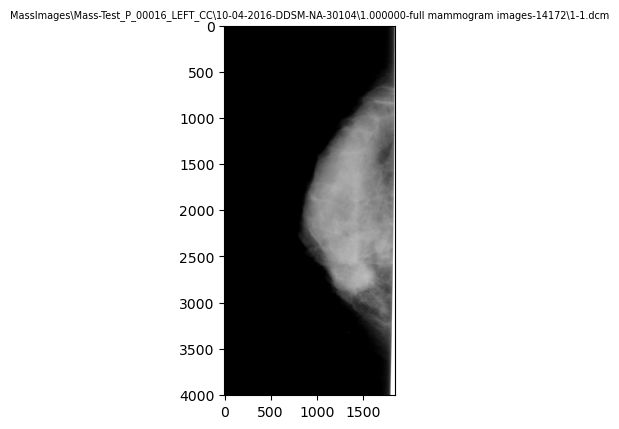

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# To obtain the dimensions of the array to store the image we will use the metadata
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))

# Then initialize in zeros an array
image = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Finally we had already read the file and we have the image information in the pixel_array (final field)
image[:,:]=RefDs.pixel_array

plt.title(data['rel_path'], fontsize=7)
plt.imshow(image, plt.cm.gray)

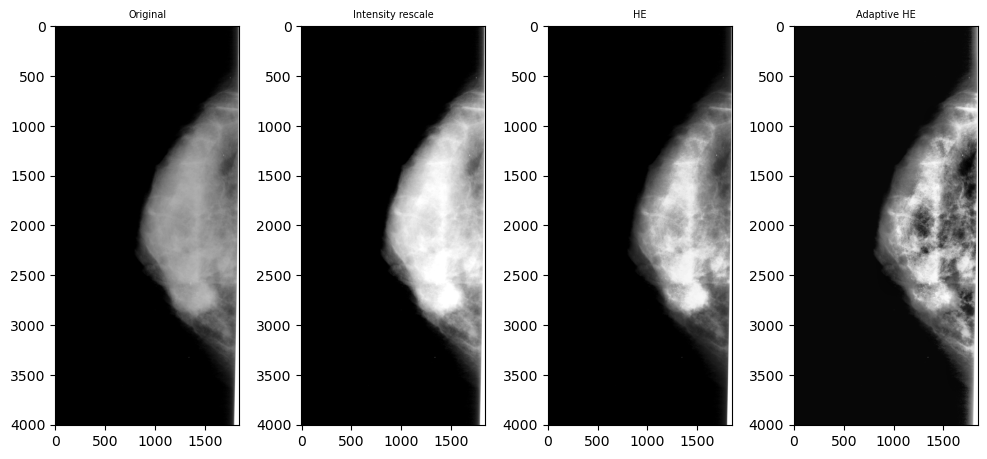

In [7]:
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
# image processing to prepare for edge detection
from skimage import exposure

# Contrast stretching
p2, p98 = np.percentile(image, (2, 98))
image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

# Equalization
image_eq = exposure.equalize_hist(image)

# Adaptive Equalization
image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)

plt.subplots(1, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(141)
plt.title("Original", fontsize=7)
plt.imshow(image, plt.cm.gray)

plt.subplot(142)
plt.title("Intensity rescale", fontsize=7)
plt.imshow(image_rescale, plt.cm.gray)

plt.subplot(143)
plt.title("HE", fontsize=7)
plt.imshow(image_eq, plt.cm.gray)

plt.subplot(144)
plt.title("Adaptive HE", fontsize=7)
plt.imshow(image_adapteq, plt.cm.gray)
plt.show()

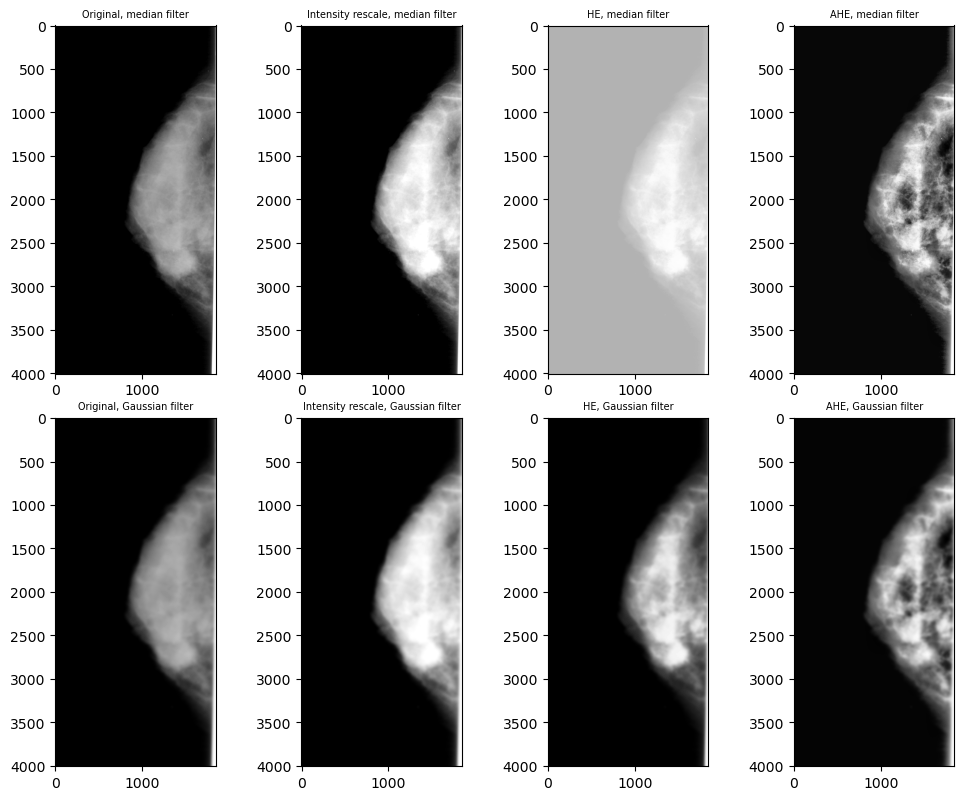

In [8]:
# smooth...
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter

images = [image, image_rescale, image_eq, image_adapteq]
images_med = [medfilt(image, 5) for image in images]
images_gaussian = [gaussian_filter(image, sigma=12) for image in images]

plt.subplots(2, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(241)
plt.title("Original, median filter", fontsize=7)
plt.imshow(images_med[0], plt.cm.gray)

plt.subplot(242)
plt.title("Intensity rescale, median filter", fontsize=7)
plt.imshow(images_med[1], plt.cm.gray)

plt.subplot(243)
plt.title("HE, median filter", fontsize=7)
plt.imshow(images_med[2], plt.cm.gray)

plt.subplot(244)
plt.title("AHE, median filter", fontsize=7)
plt.imshow(images_med[3], plt.cm.gray)

plt.subplot(245)
plt.title("Original, Gaussian filter", fontsize=7)
plt.imshow(images_gaussian[0], plt.cm.gray)

plt.subplot(246)
plt.title("Intensity rescale, Gaussian filter", fontsize=7)
plt.imshow(images_gaussian[1], plt.cm.gray)

plt.subplot(247)
plt.title("HE, Gaussian filter", fontsize=7)
plt.imshow(images_gaussian[2], plt.cm.gray)

plt.subplot(248)
plt.title("AHE, Gaussian filter", fontsize=7)
plt.imshow(images_gaussian[3], plt.cm.gray)

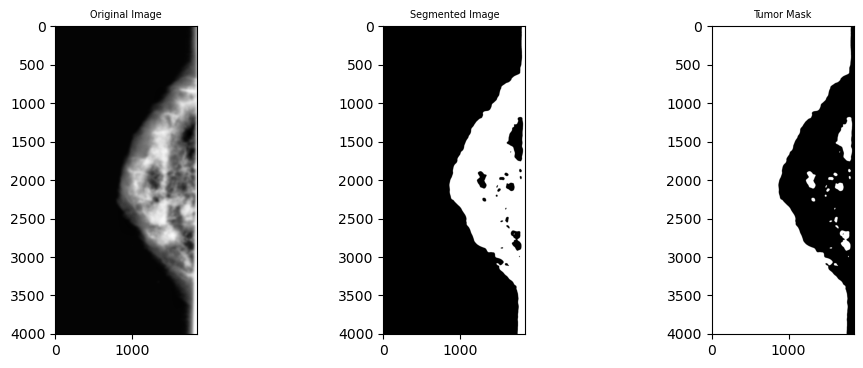

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import exposure

# Assuming the best preprocessed image is the Adaptive HE image after applying the Gaussian filter
image_to_segment = images_gaussian[3]

# Reshape the image to a 2D array of pixels
image_2D = np.reshape(image_to_segment, (image_to_segment.shape[0] * image_to_segment.shape[1], 1))

# Apply K-means clustering with 2 clusters (tumor and background)
kmeans = KMeans(n_clusters=2)
kmeans.fit(image_2D)
clustered_pixels = kmeans.labels_
centers = kmeans.cluster_centers_

# Reshape the clustered_pixels array back to the original image dimensions
segmented_image = np.reshape(clustered_pixels, image_to_segment.shape)

# Find the index of the cluster that corresponds to the tumor
tumor_cluster_index = np.argmin(centers)

# Create a binary mask for the tumor
tumor_mask = (segmented_image == tumor_cluster_index).astype(np.uint8)

# Display the original image, segmented image, and tumor mask
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title("Original Image", fontsize=7)
plt.imshow(image_to_segment, cmap=plt.cm.gray)

plt.subplot(132)
plt.title("Segmented Image", fontsize=7)
plt.imshow(segmented_image, cmap=plt.cm.gray)

plt.subplot(133)
plt.title("Tumor Mask", fontsize=7)
plt.imshow(tumor_mask, cmap=plt.cm.gray)

plt.show()

In [ ]:
# WIP. here's my to do list
# possibly increase k value
# establish which filters are ideal for this type of segmentation
# apply DICE, etc.

In [10]:
import glob

root_dir = "./MassImages/"
key = "full mammogram images"

all_files = glob.glob("MassImages/**/*.dcm", recursive=True)
filenames = [file for file in all_files if key in file]

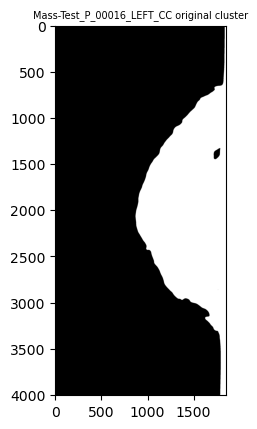

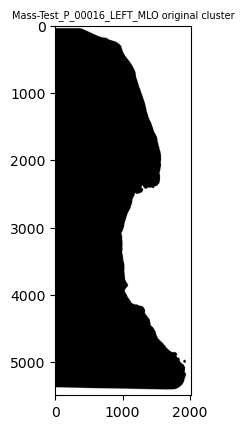

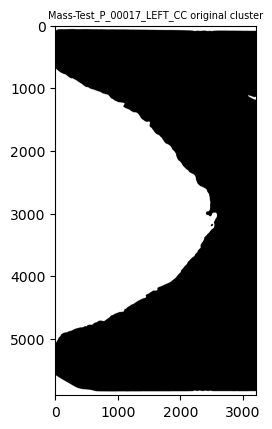

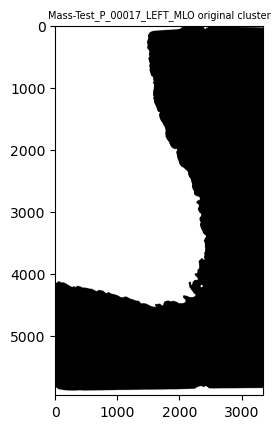

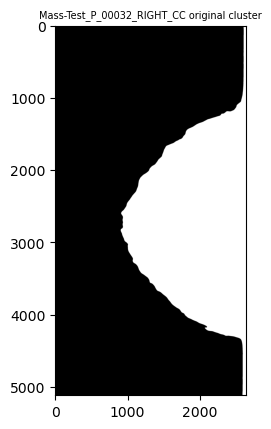

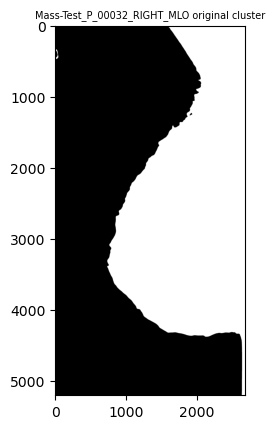

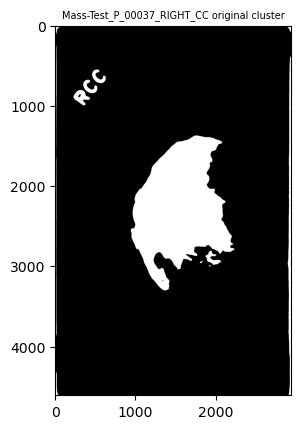

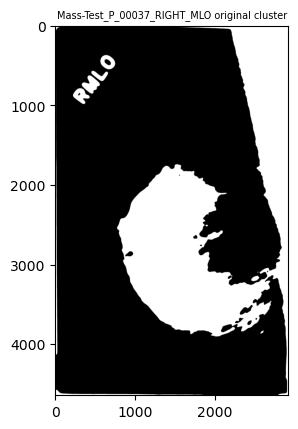

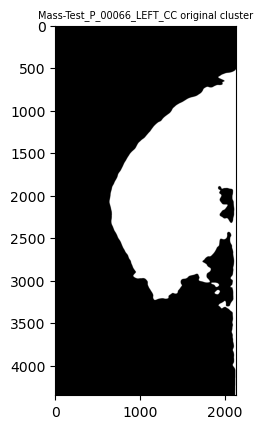

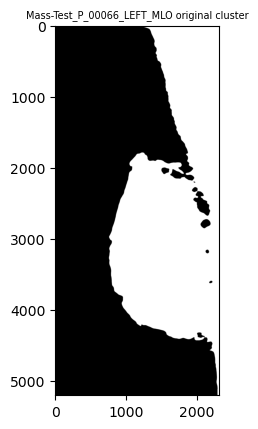

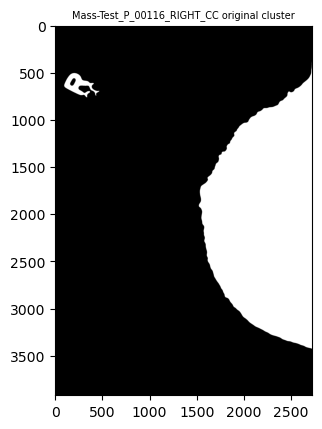

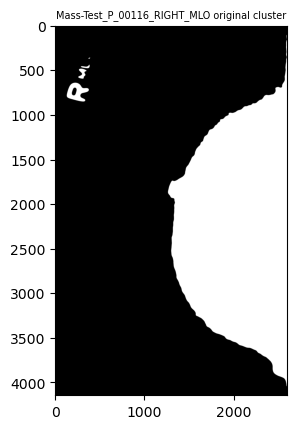

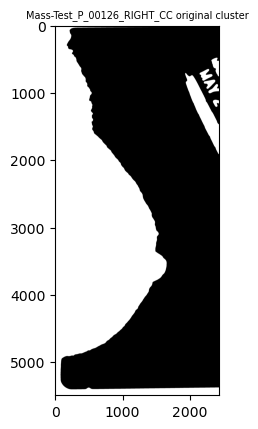

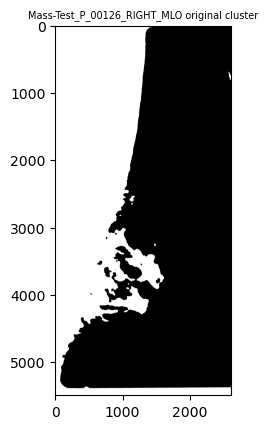

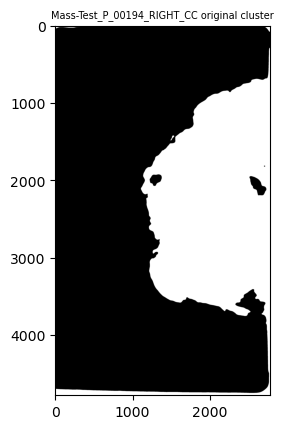

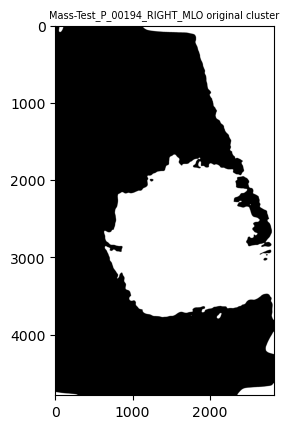

In [30]:
import numpy as np
from skimage import exposure
from scipy.ndimage import gaussian_filter
from skimage.filters import sobel
from skimage import segmentation
import pydicom
import matplotlib.pyplot as plt
import cv2

def cluster_based_segmentation(filename):
    # Load image
    RefDs = pydicom.read_file(filename)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
    image = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    image[:, :] = RefDs.pixel_array

    # Intensity rescaling
    p2, p98 = np.percentile(image, (2, 98))
    image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

    # Gaussian filter
    image_gaussian = gaussian_filter(image_rescale, sigma=12)

    # Apply K-means clustering with 2 clusters
    Z = np.float32(image_gaussian.reshape((-1, 1)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape the clustered_pixels array back to the original image dimensions
    segmented_image = label.reshape(image_gaussian.shape)

    # Swap cluster labels if the darker cluster has higher mean intensity
    if np.mean(segmented_image) > 0.5:
        segmented_image = np.logical_not(segmented_image)

    # Display
    display_name = filename.split('\\')[1]
    plt.title(display_name + " original cluster", fontsize=7)
    plt.imshow(segmented_image, plt.cm.gray)
    plt.show()

# get sample files
# filenames = ["MassImages\\Mass-Test_P_00037_RIGHT_CC\\10-04-2016-DDSM-NA-74559\\1.000000-full mammogram images-82316\\1-1.dcm", "MassImages\\Mass-Test_P_00066_LEFT_MLO\\10-04-2016-DDSM-NA-98300\\1.000000-full mammogram images-90349\\1-1.dcm", "MassImages\\Mass-Test_P_00116_RIGHT_MLO\\10-04-2016-DDSM-NA-99311\\1.000000-full mammogram images-87253\\1-1.dcm", "MassImages\\Mass-Test_P_00194_RIGHT_CC\\10-04-2016-DDSM-NA-52705\\1.000000-full mammogram images-16033\\1-1.dcm"]
# filenames = ["MassImages\\Mass-Test_P_00194_RIGHT_CC\\10-04-2016-DDSM-NA-52705\\1.000000-full mammogram images-16033\\1-1.dcm"]

for file in filenames:
    cluster_based_segmentation(file)

In [19]:
import numpy as np
from skimage import exposure
from scipy.ndimage import gaussian_filter
from skimage.filters import sobel
from skimage import segmentation
import pydicom
import matplotlib.pyplot as plt
import cv2

In [20]:
# Get filenames
import glob

key = "full mammogram images"

all_files = glob.glob("MassImages/**/*.dcm", recursive=True)
filenames = [file for file in all_files if key in file]

In [21]:
# Helpers
def update_progress(verb, idx, total):
    print((verb + " " + str(idx) + "/" + str(total)), end="\r", flush=True)

def load_image(filename):
    RefDs = pydicom.read_file(filename)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
    image = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    image[:,:]=RefDs.pixel_array
    return image

In [22]:
# Load images
images = []

for idx, filename in enumerate(filenames):
    images.append(load_image(filename))
    update_progress("Loaded", idx+1, len(filenames))

In [23]:
# Load true masks
mask_images = []

for idx, filename in enumerate(filenames):
    tokens = filename.split('\\')
    main_dir = tokens[0] + "/" + tokens[1]
    mask_filename = glob.glob(main_dir + "_1/**/*-2.dcm", recursive=True)
    mask_images.append(load_image(mask_filename[0]))
    update_progress("Loaded", idx+1, len(filenames))

In [24]:
# Get diagnoses
import pandas as pd

diagnoses = []

data = pd.read_csv("MassImages\mass_case_description_test_set.csv")

for filename in filenames:
    tokens = filename.split('\\')
    sub_tokens = tokens[1].split('_')
    patient_id = "P_" + sub_tokens[2]
    side = sub_tokens[3]
    view = sub_tokens[4]
    row = (data.loc[(data['patient_id'] == patient_id) & (data['left or right breast'] == side) & (data['image view'] == view)])
    diagnoses.append(row.iloc[0]['pathology'])
    update_progress("Found data for", idx+1, len(filenames))

In [31]:
# Segment
from skimage import exposure
from scipy.ndimage import gaussian_filter
from skimage.filters import sobel
from skimage import segmentation

images_watershed = []

def cluster_based_segmentation(image):
    # Intensity rescaling
    p2, p98 = np.percentile(image, (2, 98))
    image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    
    # Gaussian filter
    image_gaussian = gaussian_filter(image_rescale, sigma=12)
    
    # Apply K-means clustering with 2 clusters
    Z = np.float32(image_gaussian.reshape((-1, 1)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape the clustered_pixels array back to the original image dimensions
    image_cluster = label.reshape(image_gaussian.shape)

    # Swap cluster labels if the darker cluster has higher mean intensity
    if np.mean(image_cluster) > 0.5:
        image_cluster = np.logical_not(image_cluster)

for idx, image in enumerate(images):
    cluster_based_segmentation(image)
    update_progress("Segmented", idx+1, len(images))